# Assignment 2 - Classification of Australian Patent Applications

**Submission deadline: Friday <s>24 April</s> 1 May, 11pm**

**Penalty for late submission: 2 marks for each 24 period or part thereof**

**Assessment marks: 20 marks (20% of the total unit assessment)**

In this assignment you will design and evaluate several deep learning models that predict the type of Australian patent given the text of the patent application. This task and data were used in the 2018 Shared Task Competition of the Australasian Language Technology Association (the 2018 ALTA Challenge) and was hosted in Kaggle-in-Class

* [Link to download the data](https://www.kaggle.com/c/alta-2018-challenge/data)
* [Description of the 2018 ALTA Challenge](http://www.alta.asn.au/events/sharedtask2018/description.html)
* [Kaggle-in-class Competition Page](https://www.kaggle.com/c/alta-2018-challenge). Feel free to register and submit your runs!

The data set has the following files:
* `patents.zip` - The text of all patent applications. Once you unzipped, the files will be stored as individual files with the same name as the patent application ID.
* `train_data.csv` - The training set in a CSV file with annotations.
* `test_data.csv` - The test set in a CSV *without annotations*. We will not use this file for the assignment but feel free to use it to submit your runs to the ALTA 2018 Challenge if you wish.
* `samplesubmission.csv` - A sample submission file in the correct format. Again, we will not use this file for the assignment but it will be useful for you if you wish to submit runs to the ALTA 2018 Challenge.

**You are advised to start early and not to leave the exercises to the last minute since the total running time of the code may take many minutes**, depending on the hardware of your machine, and you may need to run parts of the code several times for testing and debugging.

#Student ID: 45552495
#Name: Gordon Chong Ren Ong

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [0]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
from tensorflow import keras
keras.__version__

'2.3.0-tf'

The following code reads the training data from the [ALTA 2018 Challenge](https://www.kaggle.com/c/alta-2018-challenge/data). 

In [0]:
#import pandas as pd
#pd_data = pd.read_csv('train_data.csv')
#pd_data[:5]

In [0]:
#For Google drive directory
import pandas as pd
pd_data = pd.read_csv('/content/gdrive/My Drive/dataset/train_data.csv')

In [9]:
print("Number of samples:", len(pd_data))

Number of samples: 3972


The first column is the ID of the patent application, and the second column is the patent type. There are 8 types, from "A" to "G". The following code uses Pandas to count the label types:

In [8]:
pd_data['first_ipc_mark_section'].value_counts()

A    1303
G     781
C     637
B     442
H     330
E     287
F     178
D      14
Name: first_ipc_mark_section, dtype: int64

It will look nicer using a bar plot:

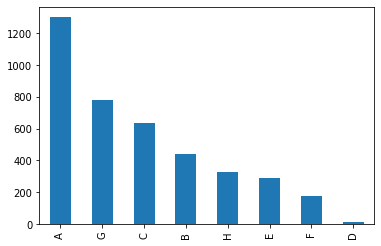

In [8]:
%matplotlib inline
pd_data['first_ipc_mark_section'].value_counts().plot.bar()

We can see that there is high imbalance in the data: The most popular class by far is "A", and class "D" is very rare.

Let's now unzip the file with the patents text, and display the beginning of one of them.

In [0]:
#Juptyer notebook
#import zipfile, os
#with zipfile.ZipFile('patents.zip', 'r') as z:
#    z.extractall('.')

In [0]:
#google colab drive
import zipfile, os
with zipfile.ZipFile('/content/gdrive/My Drive/dataset/patents.zip', 'r') as z:
    z.extractall('.')
with zipfile.ZipFile('/content/gdrive/My Drive/dataset/glove.6B.zip', 'r') as t:
    t.extractall('.') 

In [11]:
import os
print(os.listdir('patents')[:10])

['625.txt', '219.txt', '1132.txt', '3720.txt', '1275.txt', '815.txt', '2769.txt', '149.txt', '65.txt', '4705.txt']


In [12]:
with open('patents/4763.txt', encoding='iso8859-1') as f:
    text = f.read()
print(text[:1000])

                                          ABSTRACT

        A wave pool for generating surfable waves is disclosed. The wave pool includes a

pool for containing water. The pool defines a channel having a first side wall, a second side

wall, and a bottom with a contour that slopes upward from a deep area proximate the first

side wall toward a sill defined by the second side wall. The wave pool further includes at

least one foil at least partially submerged in the water near the side wall, and being adapted

for movement by a moving mechanism in a direction along the side wall for generating a

wave in the channel that forms a breaking wave on the sill. The wave pool further includes

one or more passive flow control mechanisms to mitigate a mean flow of the water induced

by the movement of the at least one foil in the direction along the side wall.


             SURFACE GRAVITY WAVE GENERATOR AND WAVE POOL

                   CROSS REFERENCE TO RELATED APPLICATIONS

[0001]        

The following code converts the Pandas data frame into a list of pairs where the first element is the file name and the second element is the classification label:

In [11]:
ids = ['patents/'+str(i)+'.txt' for i in pd_data['id']]
labels = pd_data['first_ipc_mark_section']
all_data = list(zip(ids, labels))
all_data[:3]

[('patents/0.txt', 'A'), ('patents/1.txt', 'G'), ('patents/2.txt', 'A')]

The following code splits the data in to a training set, a devtest set, and a test set. We will use it to develop our classifiers.

In [12]:
import random
random.seed(1234)
random.shuffle(all_data)
train_data, devtest_data, test_data = all_data[:2500], all_data[2500:3300], all_data[3300:]
print('Length of the partitions:', len(train_data), len(devtest_data), len(test_data))

print([x for (x,y) in train_data])

Length of the partitions: 2500 800 672
['patents/2868.txt', 'patents/744.txt', 'patents/2438.txt', 'patents/53.txt', 'patents/1529.txt', 'patents/3489.txt', 'patents/512.txt', 'patents/2911.txt', 'patents/492.txt', 'patents/1890.txt', 'patents/2642.txt', 'patents/2717.txt', 'patents/4.txt', 'patents/104.txt', 'patents/146.txt', 'patents/323.txt', 'patents/1713.txt', 'patents/2939.txt', 'patents/2297.txt', 'patents/3101.txt', 'patents/1148.txt', 'patents/1836.txt', 'patents/705.txt', 'patents/3202.txt', 'patents/449.txt', 'patents/2465.txt', 'patents/2754.txt', 'patents/1562.txt', 'patents/1653.txt', 'patents/387.txt', 'patents/2441.txt', 'patents/834.txt', 'patents/614.txt', 'patents/2102.txt', 'patents/3683.txt', 'patents/445.txt', 'patents/3686.txt', 'patents/1108.txt', 'patents/2069.txt', 'patents/1136.txt', 'patents/1649.txt', 'patents/2013.txt', 'patents/1204.txt', 'patents/3877.txt', 'patents/977.txt', 'patents/1274.txt', 'patents/957.txt', 'patents/2080.txt', 'patents/375.txt', 

# Task 1 (1 mark) - Majority Baseline

We have seen that the most popular label is 'A'. Given that, determine the accuracy of a simple baseline classifier that classifies all patent applications with the label 'A'. Calculate the accuracy for the train data, the devtest data, and the test data. Write the answer below and your calculations.

In [13]:
import numpy as np
print("Accuracy of majority baseline in the Train data:",float(np.sum(np.array(train_data) == 'A')) / len(train_data))


Accuracy of majority baseline in the Train data: 0.3344


In [16]:
#248/len(devtest_data)
print("Accuracy of majority baseline in the Devtest data:",float(np.sum(np.array(devtest_data) == 'A')) / len(devtest_data))

Accuracy of majority baseline in the Devtest data: 0.3175


In [17]:
#224/len(test_data)
print("Accuracy of majority baseline in the Test data:",float(np.sum(np.array(test_data) == 'A')) / len(test_data))


Accuracy of majority baseline in the Test data: 0.3169642857142857


# Task 2 (2 marks) - Naive Bayes
Using scikit-learn, design a Naive Bayes classifier that uses tf.idf of the input words to classify the patent applications (*hint: If you have problems with the document encoding, use the option `encoding='iso8859-1'` when you create an instance of `TfidfVectorizer`*). Limit the number of words to 10000 (*hint: use the option `max_features=10000` to limit the number of words*)

In [14]:
#Make Data Frame
data = pd_data
data['Text'] = None

for i in range(len(data['id'])):
  fileName = data.at[i, 'id']
  fileName = 'patents/' + str(fileName) + '.txt'
  with open(fileName, encoding='iso8859-1') as f:
    document = f.read()
  data['Text'][i] = document

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [15]:
data[:5]

,id,first_ipc_mark_section,Text
0,0,A,AB...
1,1,G,ABS...
2,2,A,ABS...
3,3,A,ABSTRA...
4,4,D,THERMALLY REACTIVE THERMOPLASTIC INTERMEDIATE ...


In [16]:
data.shape

(3972, 3)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english',encoding='iso8859-1',max_features=10000)
train_ids =[]
xtrain =[]
#Train lists
trainList = [x for (x,y) in train_data]
for i in trainList:
  label = i.split('/')
  label = int(label[1][:-4])
  train_ids.append(label)
train_text = [data.at[i,'Text'] for i in train_ids]
xTrain = vectorizer.fit_transform(train_text)
yTrain = [data.at[i,'first_ipc_mark_section'] for i in train_ids]

#devtestlist
devtestlist = [x for (x,y) in devtest_data]
devtest_ids =[]
xDevtest=[]
for i in devtestlist:
  label = i.split('/')
  label = int(label[1][:-4])
  devtest_ids.append(label)
Devtest_text = [data.at[i,'Text'] for i in devtest_ids]
xDevtest = vectorizer.transform(Devtest_text)
yDevtest = [data.at[i,'first_ipc_mark_section'] for i in devtest_ids]

#test list
testlist = [x for (x,y) in test_data]
test_ids =[]
xTest=[]
for i in testlist:
  label = i.split('/')
  label = int(label[1][:-4])
  test_ids.append(label)
xTest_text = [data.at[i,'Text'] for i in test_ids]
xTest = vectorizer.transform(xTest_text)
yTest = [data.at[i,'first_ipc_mark_section'] for i in test_ids]
      

In [22]:
print(yDevtest[:10])
print(xTrain.shape)
print(xDevtest.shape)
print(xTest.shape)

['E', 'G', 'B', 'B', 'G', 'G', 'B', 'A', 'G', 'A']
(2500, 10000)
(800, 10000)
(672, 10000)


In [0]:
from sklearn.naive_bayes import MultinomialNB
naivemodel = MultinomialNB()
naivemodel.fit(xTrain,yTrain)   
trainscore = naivemodel.score(xTrain,yTrain)

# Task 3 (2 marks) - Analysis of Naive Bayes

Report the accuracy of the Naive Bayes classifier on the training data, the dev-test data, and the test data, and answer the following questions:

1. Does the system improve on the majority baseline? Why?
2. Is the system overfitting? How can you determine this?

In [24]:
# Write your solution here
print("Train Score:",trainscore)
from sklearn.metrics import accuracy_score
devtest_predictions = naivemodel.predict(xDevtest)
print("Devtest Score:",accuracy_score(yDevtest, devtest_predictions))
test_predictions = naivemodel.predict(xTest)
print("Test Score:",accuracy_score(yTest, test_predictions))



Train Score: 0.608
Devtest Score: 0.55375
Test Score: 0.5565476190476191


#Analysis Of Naive Bayes:
As we can see from the train versus devetest,test scores. We can see that train scored quite well 0.608 while devtest and test are scoring 0.553, 0.556 respectively. We can also see that there is a slight amount of overfitting as the train score is slightly higher than the test score.

While comparing against the majority baseline, it seems that the system does  improve as the prediction using naive bayes did beat the percentag of (count of "A" /  Total document). As naive bayes uses conditional probabilty to predict the label results,thus, using the classifier would be better.

# Task 4 (5 marks) - Simple Neural Network

Implement a simple TensorFlow-Keras neural model that has the following sequence of layers:

1. An input layer that will accept tf.idf information
2. An output layer that can be used to classify the patent application into one of the 8 classes.

Train the layer with the tf.idf. (*Hint: sklearn produces sparse tf.idf matrices but TensorFlow models only accept dense matrices so you need to convert the tf_idf matrix of the training data into a dense Numpy array.*)

Train and test your system and report on the results. The report must answer the following questions:

1. How many parameters does the model have?
2. What was the optimal number of epochs? why?
3. Does your system overfit when training with the optimal number of epochs? How can you determine this?
4. How do the results compare against the majority baseline and the Naive Bayes implementation of Task 3?

In [18]:
import keras
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import CategoricalCrossentropy

Using TensorFlow backend.


In [0]:
model = Sequential()
model.add(Dense(8, activation='relu', input_dim=10000))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='softmax'))

In [20]:
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 80008     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
Total params: 80,288
Trainable params: 80,288
Non-trainable params: 0
_________________________________________________________________


In [0]:
from tensorflow.keras.utils import to_categorical

def numberchange(list):
    changedlist = []
    for i in list:
        if i == 'A':
          changedlist.append(0)
        if i == 'B':
          changedlist.append(1)
        if i == 'C':
          changedlist.append(2)
        if i == 'D':
          changedlist.append(3)
        if i == 'E':
          changedlist.append(4)
        if i == 'F':
          changedlist.append(5)
        if i == 'G':
          changedlist.append(6)
        if i == 'H':    
          changedlist.append(7)
    return changedlist

    
#one hot encoding and string categOrical to numerical encoding
yTrain = to_categorical(numberchange(yTrain), dtype='float32')
yDevtest = to_categorical(numberchange(yDevtest), dtype='float32')
yTest = to_categorical(numberchange(yTest), dtype='float32')

In [22]:
snn_history = model.fit(xTrain, yTrain, epochs=50, batch_size=128,validation_split=0.2)

Train on 2000 samples, validate on 500 samples
Epoch 1/50
2000/2000 [==============================] - 0s 229us/step - loss: 2.0678 - accuracy: 0.3430 - val_loss: 2.0467 - val_accuracy: 0.3720
Epoch 2/50
2000/2000 [==============================] - 0s 86us/step - loss: 2.0183 - accuracy: 0.3900 - val_loss: 1.9879 - val_accuracy: 0.3940
Epoch 3/50
2000/2000 [==============================] - 0s 87us/step - loss: 1.9416 - accuracy: 0.4220 - val_loss: 1.9013 - val_accuracy: 0.4160
Epoch 4/50
2000/2000 [==============================] - 0s 85us/step - loss: 1.8340 - accuracy: 0.4375 - val_loss: 1.7898 - val_accuracy: 0.4240
Epoch 5/50
2000/2000 [==============================] - 0s 82us/step - loss: 1.7059 - accuracy: 0.4415 - val_loss: 1.6737 - val_accuracy: 0.4180
Epoch 6/50
2000/2000 [==============================] - 0s 86us/step - loss: 1.5791 - accuracy: 0.4440 - val_loss: 1.5758 - val_accuracy: 0.4120
Epoch 7/50
2000/2000 [==============================] - 0s 87us/step - loss: 1.471

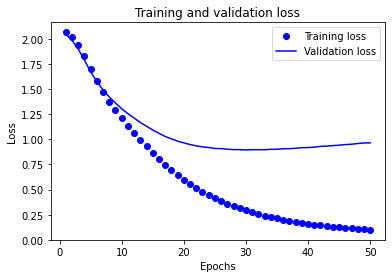

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = snn_history.history['accuracy']
val_acc = snn_history.history['val_accuracy']
loss = snn_history.history['loss']
val_loss = snn_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

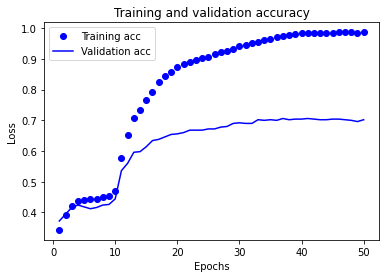

In [24]:

plt.clf()   # clear figure

acc = snn_history.history['accuracy']
val_acc = snn_history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [25]:
test_loss, test_acc = model.evaluate(xTest, yTest)
devtest_loss, devtest_acc = model.evaluate(xDevtest, yDevtest)
print('devtest_acc:', devtest_acc)
print('test_acc:', test_acc)


800/800 [==============================] - 0s 116us/step
devtest_acc: 0.6937500238418579
test_acc: 0.6473214030265808


# Simple Neural Net using callback early stopping for the optimal epoch

In [26]:
model2 = Sequential()
model2.add(Dense(8, activation='relu', input_dim=10000))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(8, activation='softmax'))
model2.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
snn_history2 = model2.fit(xTrain, yTrain, epochs=50, batch_size=128,validation_split=0.2,callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss')])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 80008     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
Total params: 80,288
Trainable params: 80,288
Non-trainable params: 0
_________________________________________________________________
Train on 2000 samples, validate on 500 samples
Epoch 1/50
2000/2000 [==============================] - 0s 146us/step - loss: 2.0703 - accuracy: 0.2935 - val_loss: 2.0546 - val_accuracy: 0.3500
Epoch 2/50
2000/2000 [==============================] - 0s 88us/step - loss: 2.0316 - accuracy: 0.3940 - val_loss: 2.0028 - val_accuracy: 0.4560
Epoch 3/50
2000/2000 [====================

In [27]:
snn2test_loss, snn2test_acc = model2.evaluate(xTest, yTest)
snn2devtest_loss, snn2devtest_acc = model2.evaluate(xDevtest, yDevtest)
print('devtest_acc:', snn2devtest_acc)
print('test_acc:', snn2test_acc)


800/800 [==============================] - 0s 113us/step
devtest_acc: 0.6899999976158142
test_acc: 0.6592261791229248


#Simple Neural Net Analysis and explanation
##how many parameters does the model have?
The model has:

Total params: 80,288

Trainable params: 80,288

Non-trainable params: 0

##What was the optimal number of epochs? why?
The optimum number of epochs would be at around 47 epoch as seem in the graph, it seems that the subesequent epochs after 47 are not any higher than the accuracy of 0.998. And it seems that the validation accuracy is not improving anymore.
Judging from the graphs the model starts overfitting at around 40 epochs.

##Does your system overfit when training with the optimal number of epochs?How can you determine this?

After using the callback function to determine the optimal number of epochs it is still overfitting as the test score is lower than the train scores. After evaulating it against the test and devtest dataset it is overfitting as train score is so much higher than the devtest and test.It seems that the model is memorising the train dataset.


##How do the results compare against the majority baseline and the Naive Bayes implementation of Task 3?

The results seems to be predicting much better than both the naive bayes and the majority baseline and it seems the best amongst the 3.


# Task 5 (5 marks) - Recurrent Neural Network

Implement a more complex neural network that is composed of the following sequence of layers:
* An embedding layer that generates embeddings with 50 dimensions. Note that the input to this layer must be a list of word indices. TensorFlow-Keras requires that this input list be of fixed length but the documents have a variable input length. For this exercise, use a fixed input length of 5000 words (*Hint: Use TensorFLow's `pad_sequences`*). Also, restrict the vocabulary to the 10000 most frequent words of the training set (*Hint: Use [Keras' tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) with the option `num_words=10000`*).
* A LSTM layer that generates an output of 60 dimensions.
* The final output layer that classifies the document into one of 8 classes.

To implement the classifier you may find useful to revise the lecture notes and associated notebooks of weeks 4 to 6. Also, refer to this [Keras Cheat Sheet](Keras_Cheat_Sheet_Python.pdf).

Train the system on the training data and evaluate the results. Compare your system with the previous systems and conduct the same kind of analysis that you did in Task 5.

In [0]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding,BatchNormalization,Flatten
from keras import preprocessing
from keras.preprocessing.text import Tokenizer
from keras.layers.core import Dense
from keras.layers import Embedding, SimpleRNN
from keras.preprocessing import sequence


In [0]:
t = Tokenizer(num_words = 10000)
t.fit_on_texts(train_text)
training = t.texts_to_sequences(train_text) 
x_train= preprocessing.sequence.pad_sequences(training, maxlen=5000)

devetesting = t.texts_to_sequences(Devtest_text) 
x_devtest= preprocessing.sequence.pad_sequences(devetesting, maxlen=5000)

testing = t.texts_to_sequences(xTest_text) 
x_test= preprocessing.sequence.pad_sequences(testing, maxlen=5000)

In [31]:
print(x_train.shape)
print(x_devtest.shape)
print(x_test.shape)

(2500, 5000)
(800, 5000)
(672, 5000)


In [32]:
modelrnn = Sequential()
modelrnn.add(Embedding(input_dim = 10000,output_dim= 50))
modelrnn.add(LSTM(60))
modelrnn.add(Dense(8, activation='softmax'))
modelrnn.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          500000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                26640     
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 488       
Total params: 527,128
Trainable params: 527,128
Non-trainable params: 0
_________________________________________________________________


In [0]:
modelrnn.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = modelrnn.fit(x_train, yTrain,epochs=30,batch_size=128,validation_data=(x_test,yTest))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2500 samples, validate on 672 samples
Epoch 1/30
2500/2500 [==============================] - 318s 127ms/step - loss: 1.8935 - acc: 0.3184 - val_loss: 1.7936 - val_acc: 0.3170
Epoch 2/30
2500/2500 [==============================] - 318s 127ms/step - loss: 1.7767 - acc: 0.3344 - val_loss: 1.7804 - val_acc: 0.3170
Epoch 3/30
2500/2500 [==============================] - 319s 128ms/step - loss: 1.7626 - acc: 0.3344 - val_loss: 1.7626 - val_acc: 0.3170
Epoch 4/30
2500/2500 [==============================] - 318s 127ms/step - loss: 1.7307 - acc: 0.3624 - val_loss: 1.6998 - val_acc: 0.3646
Epoch 5/30
2500/2500 [==============================] - 321s 128ms/step - loss: 1.6783 - acc: 0.3744 - val_loss: 1.6624 - val_acc: 0.3601
Epoch 6/30
2500/2500 [==============================] - 320s 128ms/step - loss: 1.6443 - acc: 0.3776 - val_loss: 1.7154 - val_acc: 0.3542
Epoch 7/30
2500/2500 [==============================] - 319s 127ms/step - loss: 1.6227 - acc: 0.3832 - val_loss: 1.6135 - val

In [0]:
rnntest_loss, rnntest_acc = modelrnn.evaluate(x_test, yTest)
rnndevtest_loss, rnndevtest_acc = modelrnn.evaluate(x_devtest, yDevtest)
print('test_acc:', rnntest_acc)
print('devtest_acc:', rnndevtest_acc)

800/800 [==============================] - 21s 26ms/step
test_acc: 0.4657738208770752
devtest_acc: 0.42625001072883606


In [0]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

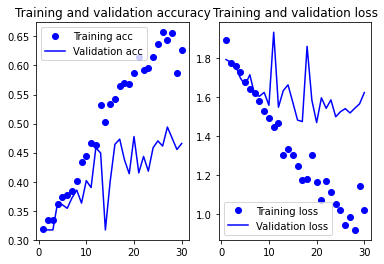

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

#plt.figure()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#RNN analysis
###how many parameters does the model have?
Total params: 527,128

Trainable params: 527,128

Non-trainable params: 0

###What was the optimal number of epochs? why?

The optimum number of epochs would be around 25 as you can see from the training accuracy graph. it shoulds that the accuracy decrease after that and this is a sign of overfitting as the model might be memorising the data.


###Does your system overfit when training with the optimal number of epochs?How can you determine this?
The model will overfit as we can see that at epoch 23 epochs onwards the accuracy seems to be decreasing.


###How do the results compare against the majority baseline and the Naive Bayes implementation of Task 3?

The result are surprisingly lower than expected as usually a more complex neural net will yield better results but was not the case here.

In terms of best performing model:

1)SNN
 
 2)Naive Bayes 
 
 3)RNN
 
 4)Baseline majority

## Task 6 (5 marks)
This final exercise is open-ended. Try to improve the system, and write below the code of your experiments and your results. Explain what you do to try to improve the results, what worked and what did not work.

Some strategies that may (or may not) work:
* Change the number of hidden cells, change the number of hidden layers.
* Change the vocabulary size or the maximum text input length.
* Add more layers up to your discretion. Note that adding layers will slow down the system.
* Use pre-trained word embeddings.
* For further inspiration, read the following research papers:
   * ["Useful information" section at the ALTA 2018 Challenge](http://www.alta.asn.au/events/sharedtask2018/info.html)
   * System descriptions of some of the participants at the ALTA 2018 Challenge ([last 3 papers of the ALTA 2018 Proceedings](https://www.aclweb.org/anthology/events/alta-2018/))

Note that the best results by participants in the Kaggle in Class competition have an accuracy of 0.778 on Kaggle's private test set. So if you manage to get near 0.77 you are doing very well indeed!
* [Kaggle in Class leaderboard](https://www.kaggle.com/c/alta-2018-challenge/leaderboard)

For this exercise, it is important that you document what you are doing and explain your reasoning. We will value a good explanation, good error analysis and good motivation. You may obtain top marks even if your system did not do well, provided that your report in this section is sound. But you may obtain low marks in this exercise if the system does well but the report is of poor quality.

The rubric for assessing this task is as follows:
* Correct code (2 marks).
* Sound methodology and evaluation (2 marks).
* Sound explanations (1 marks).

#Task 6 Report
Since we are unable to recieve more labeled training data, we will look at ways to improve accuracy by improving preprocessing of text and looking at changing the simple neural net model that gave us the best performance amongst the 4 different models used. Below all models are trained with  128 batch size and validation_split=0.2.


###Attempt 1:
During this attempt i have tried to increase the SNN model by adding more hidden layers and also increase the amount of nodes to 256. It did not yield improvement in accuracy after training:
 
####devtest_acc: 0.6899999976158142
 
####test_acc: 0.6458333134651184

This shows that adding new hidden layers will not help improving the accuracy.

### Attempt 2:
In this attempt i have tried to just increase the nodes in the hidden layer to 512 but its did not yield increase in accuracy as well in attempt 1:

####devtest_acc: 0.6937500238418579

####test_acc: 0.644345223903656

This shows that accuracy will not improve by increasing the node count, however it yielded better results than attempt 1.

###Attempt 3:
In this attempt i added in 2 hidden layer with dropouts and batchnormalization to help in reducing overfitting in hopes that i can get better accuracy.

Model used to illustrate:

modelt6 = Sequential()

modelt6.add(Dense(8, activation='relu', input_dim=10000))

modelt6.add(Dense(512, activation='relu'))

modelt6.add(Dropout(0.2))

modelt6.add(BatchNormalization())

modelt6.add(Dense(512, activation='relu'))

modelt6.add(Dropout(0.2))

modelt6.add(BatchNormalization())

modelt6.add(Dense(8, activation='softmax'))

modelt6.summary()


####devtest_acc: 0.6825000047683716

####test_acc: 0.636904776096344

In this attempt accuracy scores still are not improving but similar after training for 2000 epochs.

###Attempt 4:

In this attempt i added in a pre-trained embedding via Glove to attempt 3's model and see if there is an improvement to the data.

As we can see below the accuracys are much lower than the SNN model earlier. It might be due to the fact that pre train word embeddings might not be suitable for our current classification task. It seems that adding extra training data did not help in improving the accuracy as it might be due to the fact that sentiment in a sentence might not be similar to the conventional text that you see in essays. Its sentiments might be different and cause problems with our accuracy.

Decoding human language using machine learning is also very difficult as different sentences can bring different meanings, this might be the case here as patents might have sentences that are of different meanings in 'Patents' than other corpuses. 



In [0]:
print(train_text[:5])

['I:\\sxd\\Interwoven\\NRPortbl\\DCC\\SXD\\ 6389646 _docx-6 02 2018\n\n                                                               ABSTRACT\n\n                                              HO            0\n\n                                                                   R1\n\n                                                                   N-A--Y\n\n                                                              N           (I)\n\n                The present application discloses compounds capable of modulating the activity\n\nof histone demethylases (HDMEs), which are useful for prevention and/or treatment of\n\ndiseases in which genomic dysregulation is involved in the pathogenesis, such as\n\ne.g. cancer. The present application also discloses pharmaceutical compositions\n\ncomprising said compounds and the use of such compounds as a medicament. The\n\ncompounds take the form (I).\n\n\nI:\\sxd\\Interwoven\\NRPortbl\\DCC\\SXD\\ 6389646 _docx-6 02 2018\n\n                      

In [0]:
import numpy as np
word_index = t.word_index
print('Found %s unique tokens.' % len(word_index))


Found 717922 unique tokens.


In [0]:
glove_dir = ''

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 100
max_words=10000
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [0]:
from keras.layers import Dropout, BatchNormalization
modelt6 = Sequential()
modelt6.add(Embedding(max_words, embedding_dim, input_length=5000))
modelt6.add(Flatten())
modelt6.add(Dense(64, activation='relu'))
modelt6.add(Dropout(0.2))
modelt6.add(BatchNormalization())
modelt6.add(Dense(8, activation='softmax'))
modelt6.layers[0].set_weights([embedding_matrix])
modelt6.layers[0].trainable = False
modelt6.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 5000, 100)         1000000   
_________________________________________________________________
flatten_12 (Flatten)         (None, 500000)            0         
_________________________________________________________________
dense_33 (Dense)             (None, 64)                32000064  
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 64)                256       
_________________________________________________________________
dense_34 (Dense)             (None, 8)                 520       
Total params: 33,000,840
Trainable params: 32,000,712
Non-trainable params: 1,000,128
_________________________________

#epochs T6snn


In [0]:
modelt6.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
t6 = modelt6.fit(x_train, yTrain,epochs=100,batch_size=128,validation_data=(x_test,yTest))
#,callbacks=[keras.callbacks.EarlyStopping(monitor='loss')]

Train on 2500 samples, validate on 672 samples
Epoch 1/100
2500/2500 [==============================] - 2s 689us/step - loss: 0.0302 - acc: 0.9912 - val_loss: 1.6941 - val_acc: 0.5149
Epoch 2/100
2500/2500 [==============================] - 1s 545us/step - loss: 0.0285 - acc: 0.9904 - val_loss: 1.8755 - val_acc: 0.4985
Epoch 3/100
2500/2500 [==============================] - 1s 547us/step - loss: 0.0269 - acc: 0.9904 - val_loss: 1.6590 - val_acc: 0.5193
Epoch 4/100
2500/2500 [==============================] - 1s 546us/step - loss: 0.0250 - acc: 0.9924 - val_loss: 2.6338 - val_acc: 0.4866
Epoch 5/100
2500/2500 [==============================] - 1s 544us/step - loss: 0.0337 - acc: 0.9908 - val_loss: 2.1564 - val_acc: 0.4435
Epoch 6/100
2500/2500 [==============================] - 1s 544us/step - loss: 0.0308 - acc: 0.9880 - val_loss: 2.6144 - val_acc: 0.4167
Epoch 7/100
2500/2500 [==============================] - 1s 547us/step - loss: 0.0295 - acc: 0.9904 - val_loss: 2.0127 - val_acc: 0

In [0]:
 t6test_loss, t6test_acc = modelt6.evaluate(x_test, yTest)
t6devtest_loss, t6devtest_acc = modelt6.evaluate(x_devtest, yDevtest)
print('devtest_acc:', t6devtest_acc)
print('test_acc:', t6test_acc)

800/800 [==============================] - 0s 273us/step
devtest_acc: 0.5012500286102295
test_acc: 0.4925595223903656


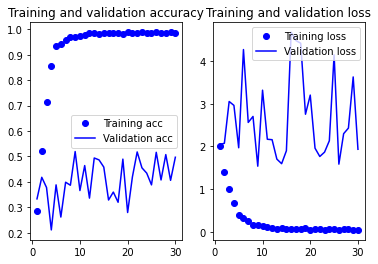

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = t6.history['acc']
val_acc = t6.history['val_acc']
loss = t6.history['loss']
val_loss = t6.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

#plt.figure()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Conclusion

After the various attempts of trial & error, it is safe to say that the Simple Neural net is the best model to predict patents with our current dataset.

Below we can see a list of all performance accuracys that are compared with the other different models tested.


In [0]:
accuracylistdev= [0.3175,0.55375,0.7049999833106995,0.42625001072883606,0.6899999976158142,0.6937500238418579,0.6825000047683716,0.5012500286102295]
accuracylisttest = [0.3169642857142857,0.5565476190476191,0.668154776096344,0.4657738208770752,0.6458333134651184,0.644345223903656,0.636904776096344,0.4925595223903656]
names= ['Majority Baseline','Naive Bayes','SNN','RNN','Attempt 1','Attempt 2','Attempt 3','Attempt 4']

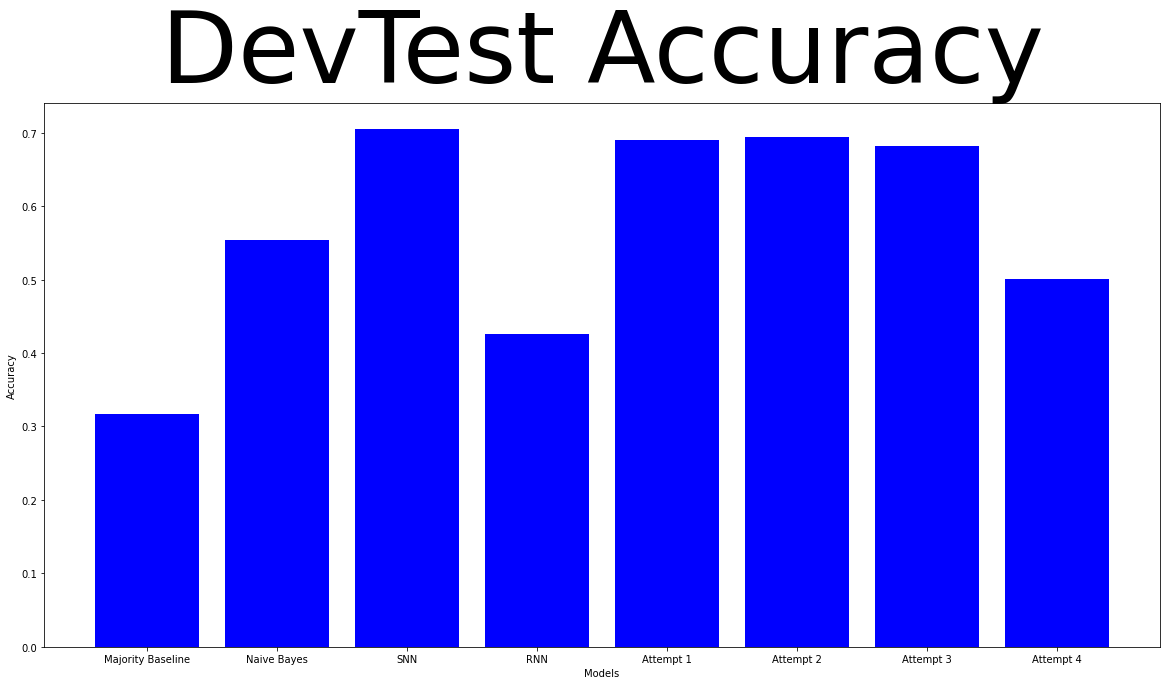

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.bar(names, accuracylistdev, color ='blue')
plt.title('DevTest Accuracy',fontsize=100)
plt.xlabel('Models')
plt.ylabel('Accuracy') 
plt.show()

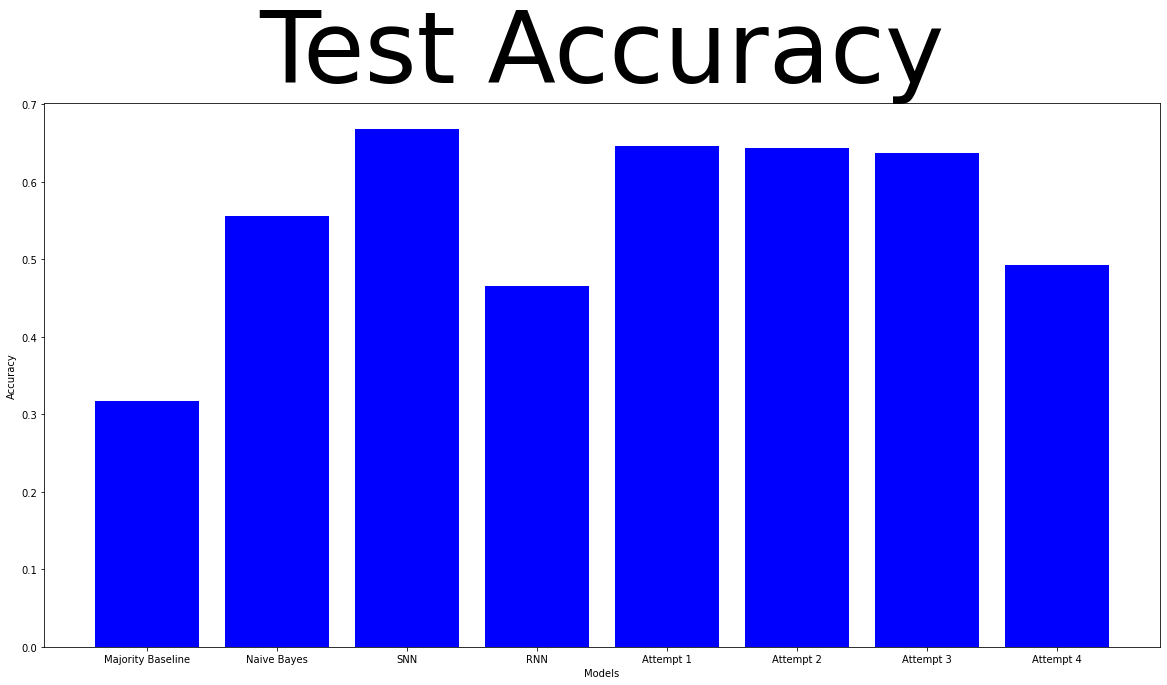

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.bar(names, accuracylisttest, color ='blue')
plt.title('Test Accuracy',fontsize=100)
plt.xlabel('Models')
plt.ylabel('Accuracy') 
plt.show()

# Submission of Results

Your submission should consist of this Jupyter notebook with all your code and explanations inserted into the notebook. The notebook should contain the output of the runs.

Examine the cells of this notebook so that you can have an idea of how to format text for good visual impact. You can also read this [useful guide to the MarkDown notation](http://daringfireball.net/projects/markdown/syntax), which explains the format of the text.

Each question specifies a mark. The final mark of the assignment is the sum of all the individual marks, after applying any deductions for late submission.

By submitting this assignment you are acknowledging that this is your own work. Any submissions that break the code of academic honesty will be penalised as per [the academic integrity policy](https://staff.mq.edu.au/work/strategy-planning-and-governance/university-policies-and-procedures/policies/academic-integrity).
